In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics 
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, DBSCAN

In [2]:
data = pd.read_csv('german_credit_data.csv')

In [3]:
data.shape

(1000, 10)

In [4]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


4 непрерывных и 5 категориальных величин, 1 идентификатор, который нужно удалить. Есть пропусти

In [5]:
#Первая колонка просто идентификатор, посмотрим на дубликаты
sum(data['Unnamed: 0'].duplicated())

0

In [6]:
#идентификатор - уникальные значения , не информативный признак нужно удалить
data.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
#Проверим кол-во пустых значений
data.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Две колонки содержать пустые значения , нужно обработать. Можно предположить, что у этих пользователей нет одного из акаунтов.Заменим пыстые значения на еще одно значение признака

In [8]:
for column in ['Saving accounts', 'Checking account']:
    data[column][data[column].isnull()] = 'absent'

In [9]:
data.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64

In [10]:
objs = list(data.select_dtypes(include=['object']).columns)

In [11]:
data.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [13]:
data.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       5
Checking account      4
Credit amount       921
Duration             33
Purpose               8
dtype: int64

In [14]:
print('Уникальные значения для каждой категориальной колонки:')
for col in data.select_dtypes(include=[object]):
    print(col,":",data[col].unique())

Уникальные значения для каждой категориальной колонки:
Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : ['absent' 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' 'absent' 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


Exploratory Data Analysis

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Job'}>],
       [<AxesSubplot:title={'center':'Credit amount'}>,
        <AxesSubplot:title={'center':'Duration'}>]], dtype=object)

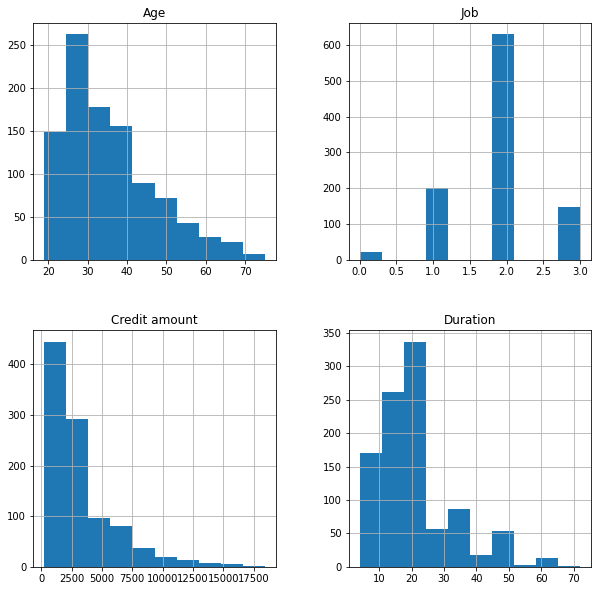

In [15]:
data.hist(figsize=(10,10))

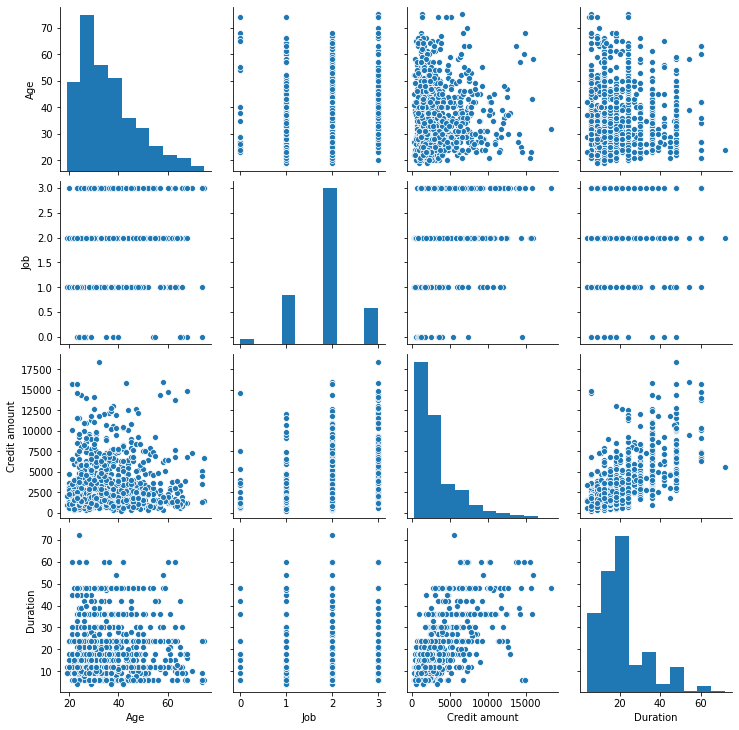

In [16]:
sns.pairplot(data);

существует определенная положительная корреляция между продолжительностью и суммой кредита. В остальном корреляции не видно

In [17]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,10))
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    plt.tight_layout()

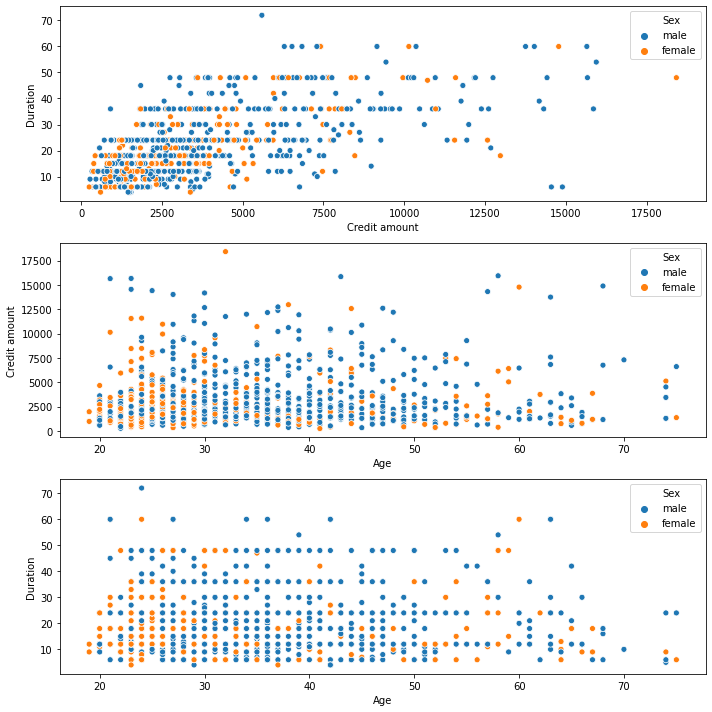

In [18]:
scatters(data, h="Sex")

Посмотрим линейную корреляцию размером кредита и продолжительностью

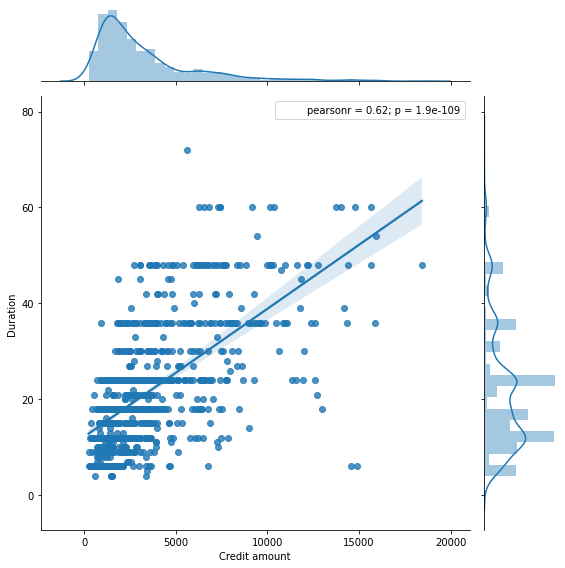

In [19]:
import scipy.stats as stats
r1 = sns.jointplot(x="Credit amount", y="Duration", data=data, kind="reg", height=8)
r1.annotate(stats.pearsonr)
plt.show()

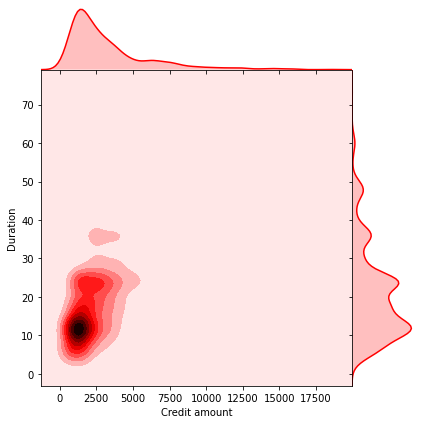

In [20]:
sns.jointplot("Credit amount","Duration", data=data, kind="kde", space=0, color="r")

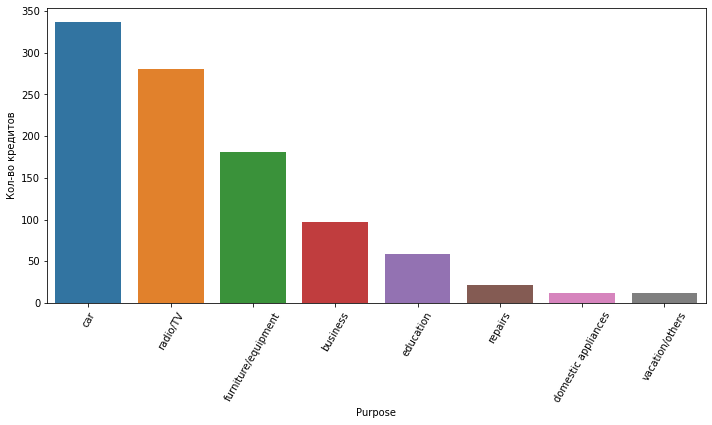

In [21]:
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Кол-во кредитов")
plt.tight_layout()

In [22]:
def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

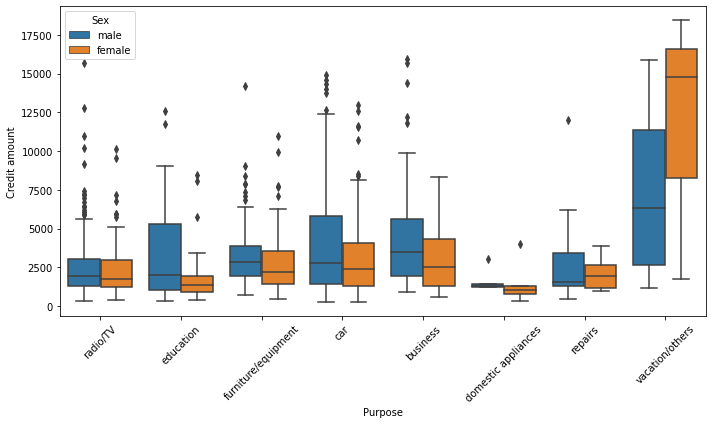

In [23]:
boxes("Purpose","Credit amount","Sex")

В целом цели кредитов совпадают, женщины берут болше кредитов на отпуск

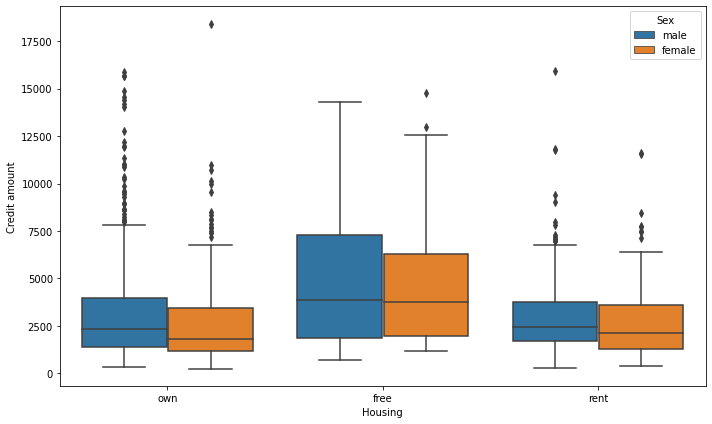

In [24]:
boxes("Housing","Credit amount","Sex",r=0)

люди с бесплатным жильем берут кредиты с большими суммами

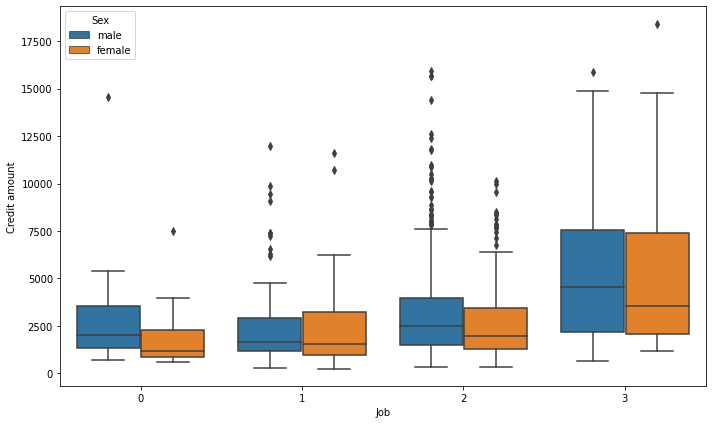

In [25]:
boxes("Job","Credit amount","Sex",r=0)

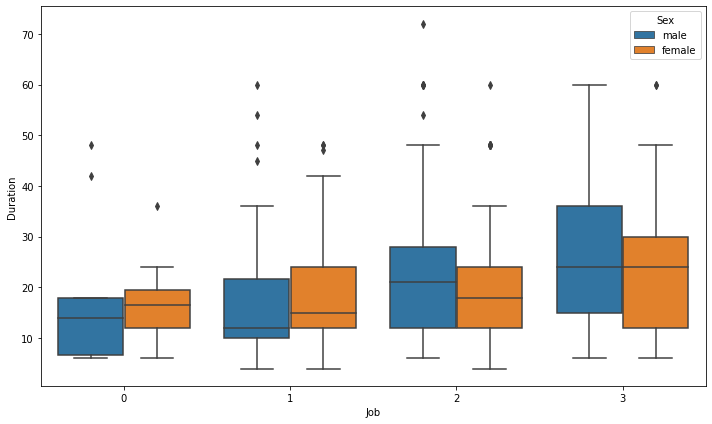

In [26]:
boxes("Job","Duration","Sex",r=0)

Чем больше работ, тем большие по размеру и на больший срок берутся кредиты
Еще инетересно посмотреть размер кредита и продолжительность от возроста

Text(0.5, 0, 'Age')

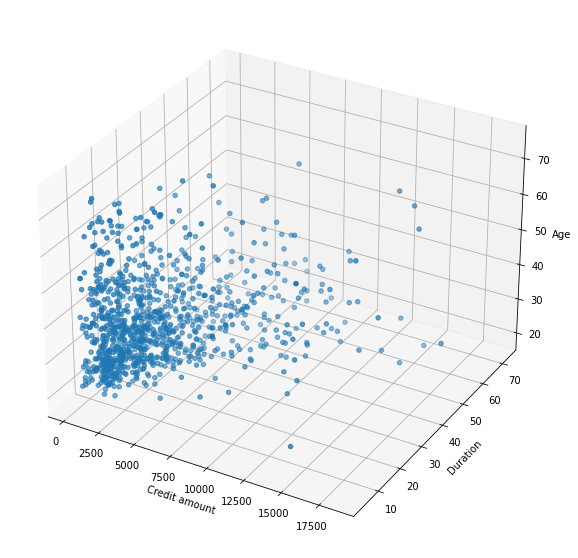

In [27]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["Credit amount"], data["Duration"], data["Age"])
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")

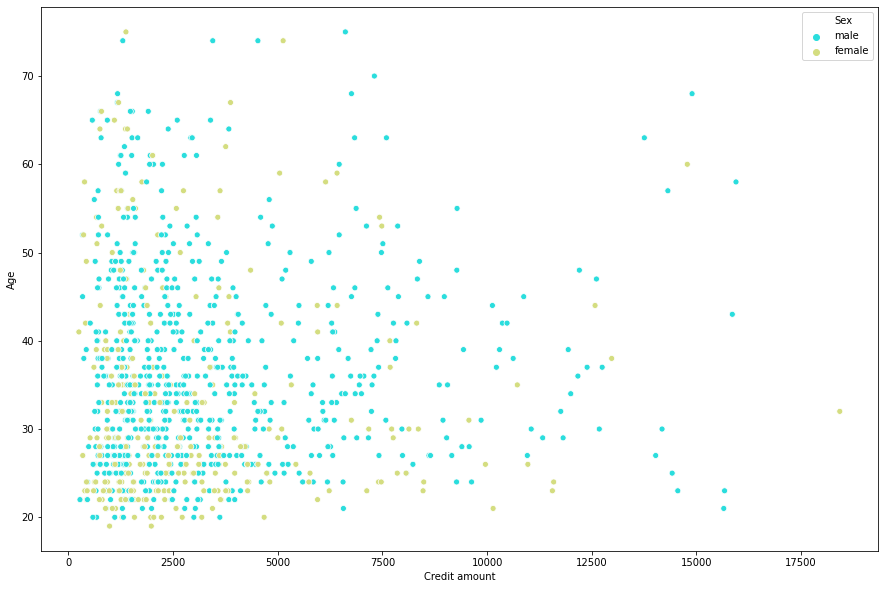

In [28]:
fig = plt.figure(figsize=(15,10))
ax = sns.scatterplot(x="Credit amount", y="Age", hue='Sex',
                 data=data, palette="rainbow")

Из визуализации видно, что по полу нет значительного различия в поведении, признак не стоит учитывать в разбиении 

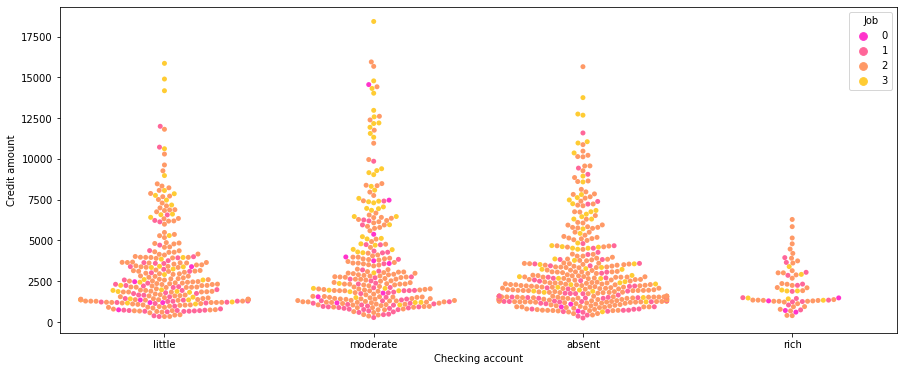

In [29]:
fig = plt.figure(figsize=(15,6))
ax=sns.swarmplot(x="Checking account", y="Credit amount", hue="Job", data=data, palette="spring")

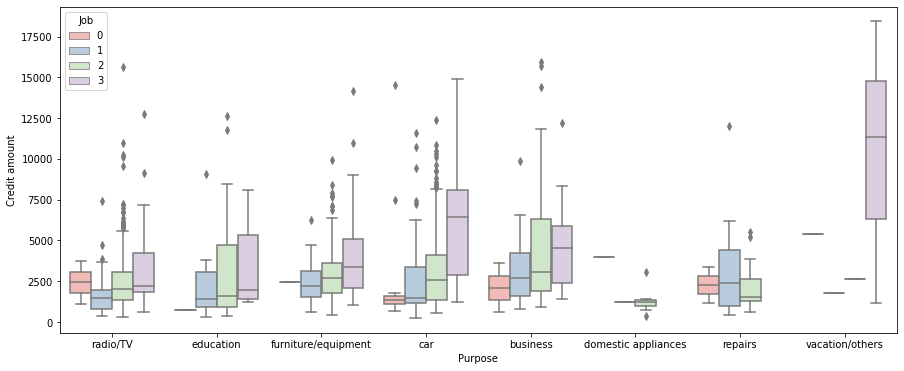

In [30]:
## Corr between Credit amount and Purpose by Job

fig = plt.figure(figsize=(15,6))
ax = sns.boxplot(x="Purpose", y="Credit amount", hue='Job',
                 data=data, palette="Pastel1")

In [31]:
categorical_col = list(data.select_dtypes(include=['object']).columns)
print(categorical_col)
#label = LabelEncoder()
#for column_cat in categorical_col:
#    label.fit(data[column_cat].drop_duplicates())
#    data[column_cat] = label.transform(data[column_cat])

['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']


In [32]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,absent,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,absent,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [33]:
#Selecting columns for clusterisation with k-means
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]

In [34]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

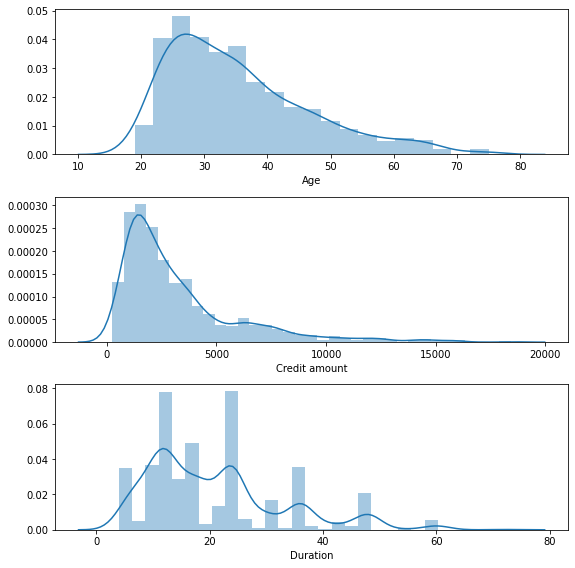

In [35]:
distributions(cluster_data)

Распределения смещены вправа, следовательно нужно логорифмировать

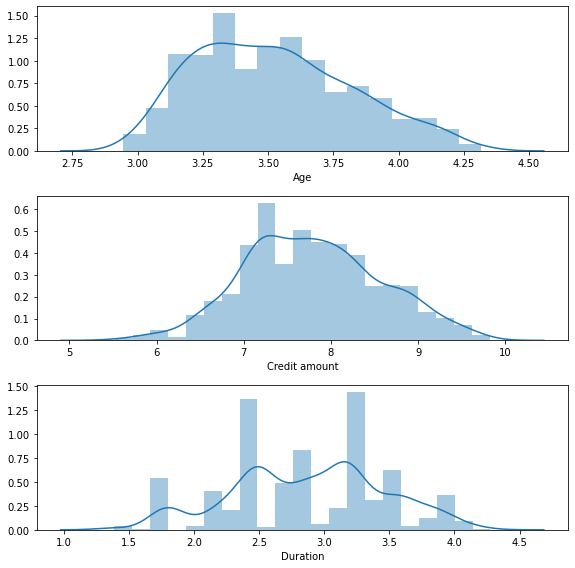

In [36]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

Распределения стали больше похожеми на нормальные, логорифмиование помогло

## Моделирование

KMeans требует центррирование и масштабирование переменных

In [37]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

KMeans требует задание кол-ва кластеров. Подберем оптимальное количество кластеров для каждого метода при помощи Elbow method и Silhouette plot

Elbow method - метод логтя.
Метод состоит из построения объясненной вариации как функции количества кластеров и выбора изгиба кривой в качестве количества используемых кластеров. Тот же метод можно использовать для выбора количества параметров в других моделях, управляемых данными, например количества основных компонентов для описания набора данных.

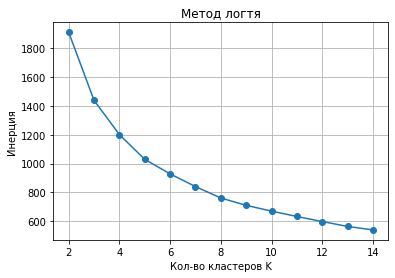

In [38]:
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.xlabel('Кол-во кластеров K') 
plt.ylabel('Инерция') 
plt.title('Метод логтя')
plt.grid()
plt.plot(clusters_range,inertias, marker='o',)

инерция уменьшается с увеличением количества кластеров. По данному графику кажется 4-5 кластеров

In [39]:
distortions = []
mapping1 = {}
K = range(1,15) 

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(cluster_scaled)
    kmeanModel.fit(cluster_scaled)

    distortions.append(sum(np.min(cdist(cluster_scaled, kmeanModel.cluster_centers_, 
                    'euclidean'),axis=1)) / cluster_scaled.shape[0]) 

    mapping1[k] = sum(np.min(cdist(cluster_scaled, kmeanModel.cluster_centers_, 
                'euclidean'),axis=1)) / cluster_scaled.shape[0]

In [40]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

1 : 1.5942087626050723
2 : 1.2777806628684054
3 : 1.1102428082975213
4 : 1.0119878472398753
5 : 0.9354304605855296
6 : 0.8868725664744735
7 : 0.8508779124963339
8 : 0.8090109524834083
9 : 0.7802834804431958
10 : 0.7544598045558303
11 : 0.7297575252644648
12 : 0.7111444959607295
13 : 0.6930813280629676
14 : 0.6785765699680322


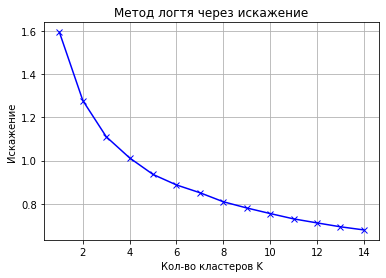

In [41]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Кол-во кластеров K') 
plt.ylabel('Искажение') 
plt.title('Метод логтя через искажение')
plt.grid()
plt.show() 

по этому графику кажется 4 будет оптимальным

По дендрограмме 3-4 кластера

Silhouette plot относится к методу интерпретации и проверки согласованности в пределах кластеров данных . Этот метод дает краткое графическое представление о том, насколько хорошо каждый объект был классифицирован.

Значение силуэта является мерой того, насколько объект похож на его собственный кластер (сцепление) по сравнению с другими кластерами (разделение). Силуэт варьируется от -1 до +1

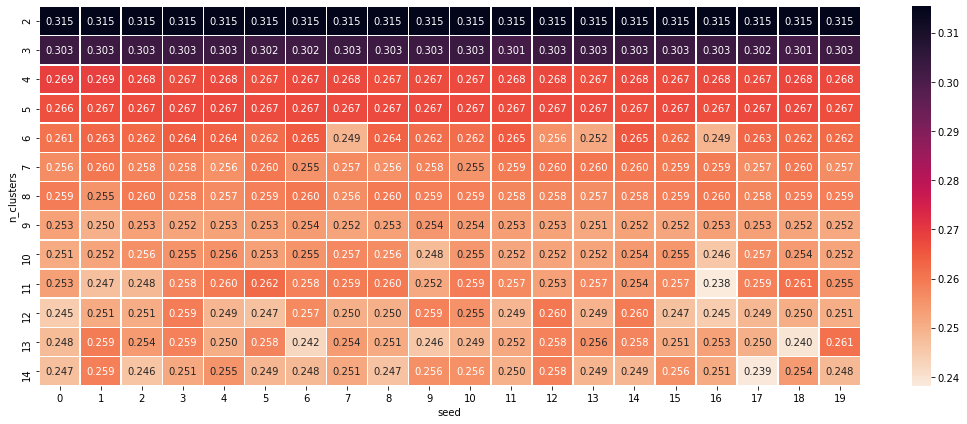

In [42]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

For n_clusters = 3  and seed = 19 
The average silhouette_score is : 0.3033583951666899


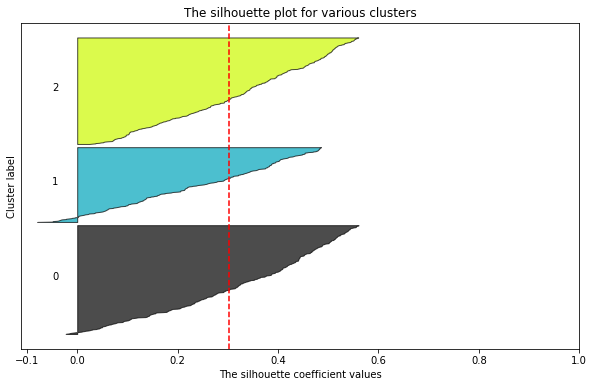

In [43]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=3, random_state=10)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("For n_clusters =", 3," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(3):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.get_yaxis().set_ticks([])
ax1.set_title("The silhouette plot for various clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

For n_clusters = 4  and seed = 19 
The average silhouette_score is : 0.2672008604922298


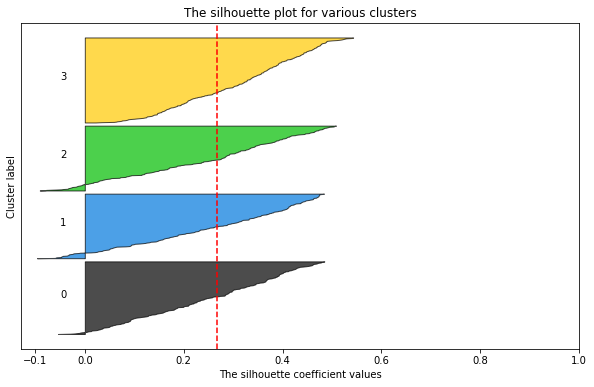

In [44]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("For n_clusters =", 4," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(4):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 4)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.get_yaxis().set_ticks([])
ax1.set_title("The silhouette plot for various clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

Оценки силуэтов наиболее высокие по тепловой карте для 2-4 кластеров. По силуэтному графику 4

В результате анализа, возьмем 4 

In [45]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(cluster_scaled)
y_pred = kmeans.predict(cluster_scaled)
print(kmeans.cluster_centers_)

[[ 1.30120334 -0.28779697 -0.38897056]
 [ 0.1391263   1.27866775  1.17681616]
 [-0.45466254 -0.92383902 -1.0332481 ]
 [-0.64212305  0.06452455  0.30711697]]


In [46]:
data_kmeans_copy = data.copy(deep=True)
data_kmeans_copy["label"] = kmeans.labels_
labels = kmeans.labels_
centers = kmeans.cluster_centers_
data_kmeans_copy.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,label
0,67,male,2,own,absent,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,absent,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,0


Text(0.5, 0, 'Age')

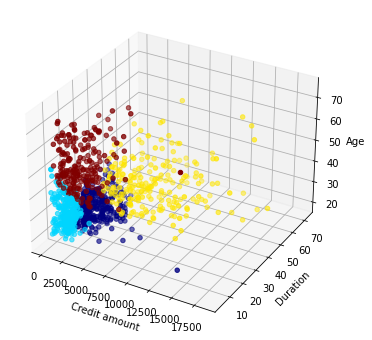

In [47]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["Credit amount"], data["Duration"], data["Age"], c=y_pred, cmap='jet_r')
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")

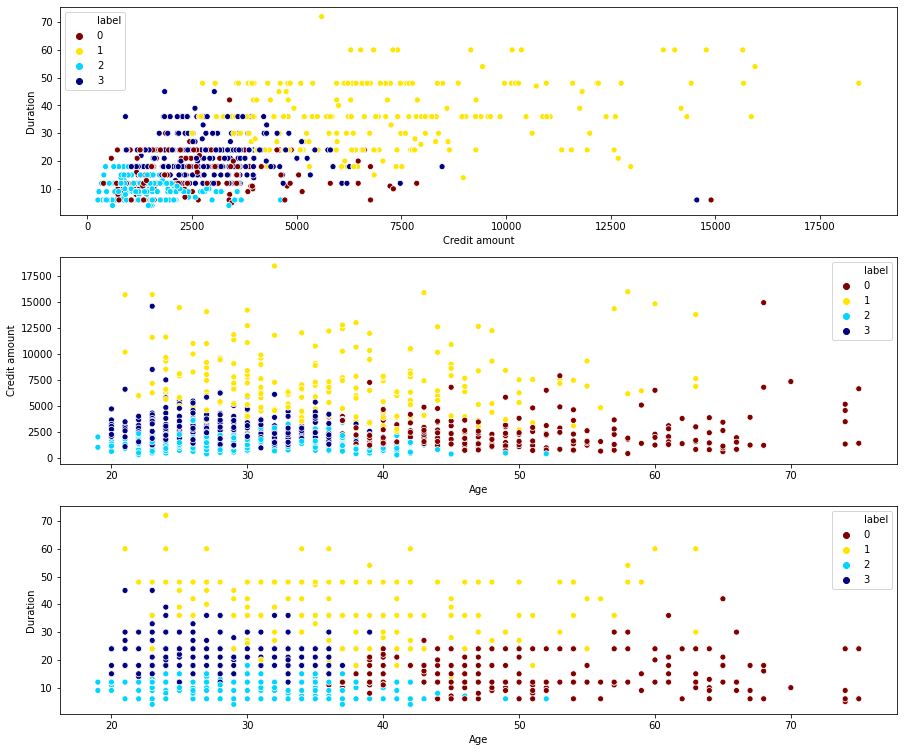

In [48]:
f = plt.figure(figsize=(15,13))
ax = f.add_subplot(311)
ax = sns.scatterplot(x="Credit amount", y="Duration", hue='label', data=data_kmeans_copy, palette="jet_r")
ax = f.add_subplot(312)
ax = sns.scatterplot(x="Age", y="Credit amount", hue='label', data=data_kmeans_copy, palette="jet_r")
ax = f.add_subplot(313)
ax = sns.scatterplot(x="Age", y="Duration", hue='label', data=data_kmeans_copy, palette="jet_r")

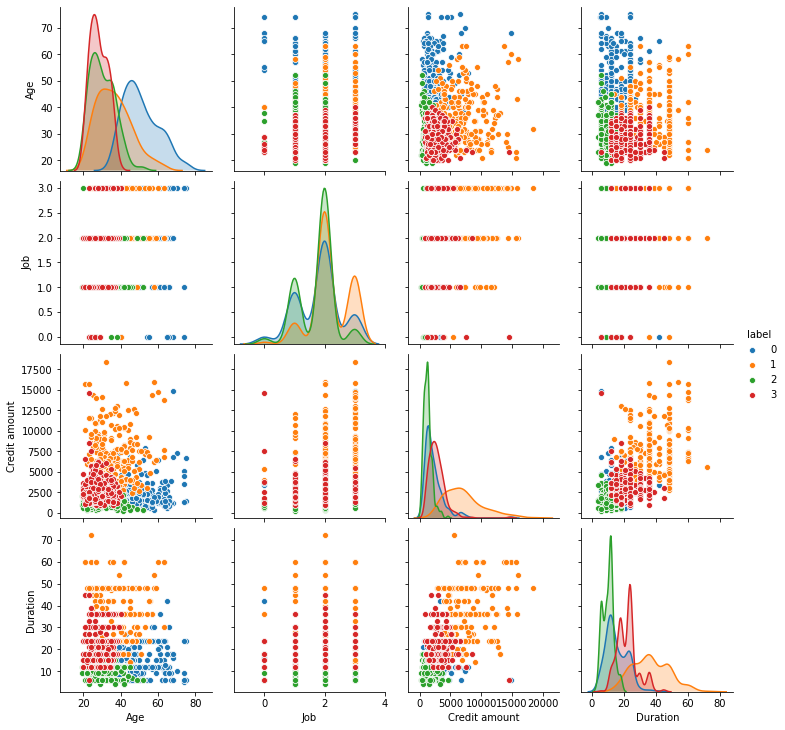

In [49]:
sns.pairplot(data_kmeans_copy, hue='label')

## Сжатие признакового просранства

2.Также воспользуйтесь различными вариантами сжатия признакового пространства (PCA, tSNE) и визуализируйте результаты кластеризации на двумерной плоскости

 проклятие размерности:
    1)Делает обучение очень медленным
    2)Затрудняет поиск хорошего решения

уменьшение размерности - это процесс сокращения количества признаков до наиболее актуальных (с наименьшей потерей информации и искажением)

t-SNE (T-распределенное стохастическое вложение соседей)
берет большой набор данных и сокращает его до низкоразмерного графа, который сохраняет большую часть исходной информации.

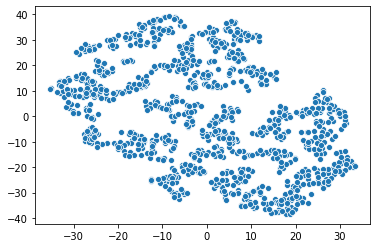

In [50]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=10)
cluster_scaled.shape
X_tsne = tsne.fit_transform(cluster_scaled)
sns.scatterplot(X_tsne[:,0], X_tsne[:,1]);

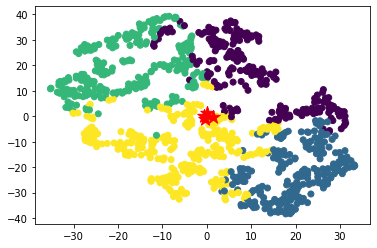

In [51]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=data_kmeans_copy["label"]);
plt.scatter(centers[:,0], centers[:,1], marker = '*', s=200, c='r');

Центры странно расположены в двухмерном пространстве TSNE

PCA (анализ главных компонент), он работает путем определения гиперплоскости, которая находится ближе всего к данным, а затем проецирует данные на эту гиперплоскость, сохраняя при этом большую часть вариаций в наборе данных.



Text(0, 0.5, 'cumulative explained variance')

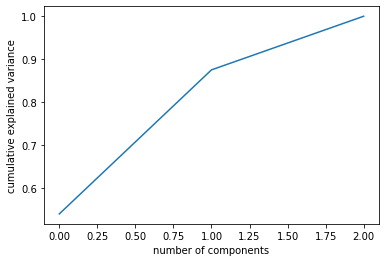

In [52]:
from sklearn.decomposition import PCA
pca = PCA().fit(cluster_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

График коэффициента дисперсии, ряд компонентов, которые "capture" по крайней мере 95% дисперсии. В данном случае число компонентов, которые захватывают около 95% дисперсии = 2

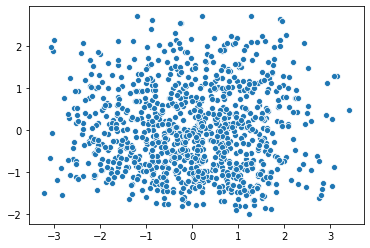

In [53]:
pca = PCA(n_components=2)
pca.fit(cluster_scaled)
pca_samples = pca.transform(cluster_scaled)
sns.scatterplot(pca_samples[:,0], pca_samples[:,1]);

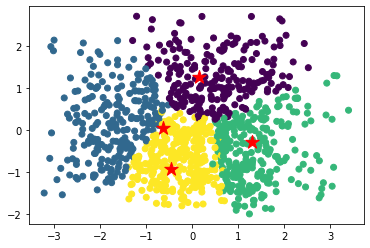

In [54]:
plt.scatter(pca_samples[:,0], pca_samples[:,1], c=data_kmeans_copy["label"]);
plt.scatter(centers[:,0], centers[:,1], marker = '*', s=200, c='r');

In [55]:
data_kmeans_copy.groupby('label').mean()

,Age,Job,Credit amount,Duration
label,,,,
0,50.967442,1.809302,2301.525581,15.502326
1,36.511211,2.192825,7119.403587,36.878924
2,30.283525,1.743295,1330.624521,10.295019
3,28.378738,1.897010,2795.714286,22.122924


Выводы из KMeans 
В банке выделилось четыре типа клиентов:

0 - средние по возрасту клиенты с большими кредитами и сроками

1 - молодые клиенты со средними сроком и небольшой суммой кредита

2 - взрослые клиенты с малыми сроками и небольшой суммой кредита

3 - молодые клиенты с малыми сроками и малой суммой



hierarhical - Иерархическая кластеризация

Agglomerative clustering - Агломеративная кластеризация. Новые кластеры создаются путем объединения более мелких кластеров и, таким образом, дерево создается от листьев к стволу;

Divise clustering - Дивизивная кластеризация. Кластеры создаются путем деления более крупных кластеров на более мелкие и, таким образом, дерево создается от ствола к листьям.

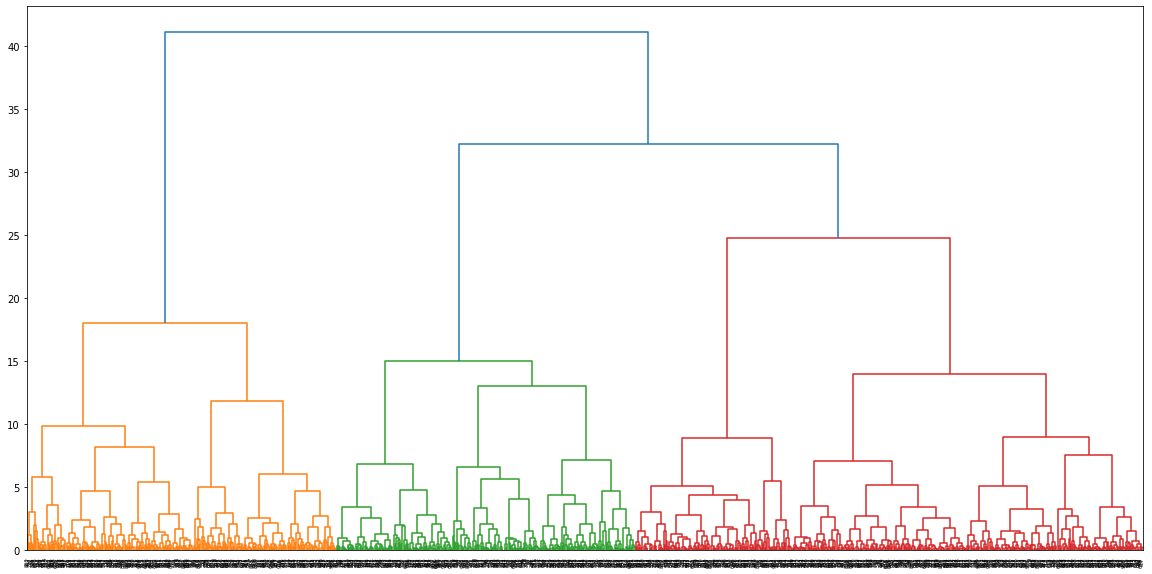

In [56]:
#Дендрограмма
plt.figure(figsize=(20,10))
linkage_ = linkage(cluster_scaled, method='ward')
dendrogram_ = dendrogram(linkage_)

По дендрограмме 3-4 кластера кажется приемлемым

In [57]:
silhouette = []
for i in range(2,20):
    agg = AgglomerativeClustering(n_clusters=i).fit(cluster_scaled)
    labels = agg.labels_
    score = silhouette_score(cluster_scaled, labels)
    silhouette.append(score)

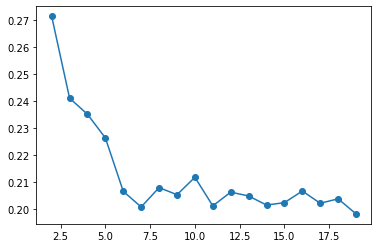

In [58]:
plt.plot(range(2,20), silhouette, marker='o');

по силуэтному скорумаксимум в 2 кластерах. Не совсем красивый показатель, сложно следать выводы

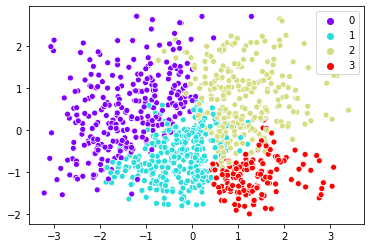

In [59]:
agg = AgglomerativeClustering(n_clusters=4).fit(cluster_scaled)
labels = agg.labels_
sns.scatterplot(pca_samples[:,0], pca_samples[:,1], hue=labels, palette='rainbow');

DBSCAN Это алгоритм кластеризации, основанной на плотности — если дан набор точек в некотором пространстве, алгоритм группирует вместе точки, которые тесно расположены

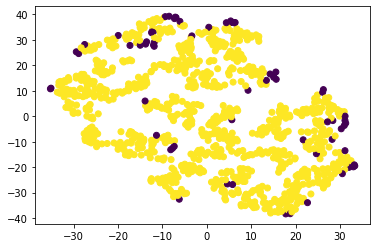

In [60]:
dbscan = DBSCAN().fit(cluster_scaled)
labels = dbscan.labels_
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels);

In [61]:
silhouette = []
clusters = []
eps_range = np.arange(0.1,2,0.1)
for i in eps_range:
    dbscan = DBSCAN(eps=i).fit(cluster_scaled)
    labels = dbscan.labels_
    uniq_labels = np.unique(labels)
    n_clusters = len(uniq_labels[uniq_labels != -1])
    if n_clusters > 1:
        score = silhouette_score(cluster_scaled, labels)
    else:
        score = 0
    silhouette.append(score)
    clusters.append(n_clusters)

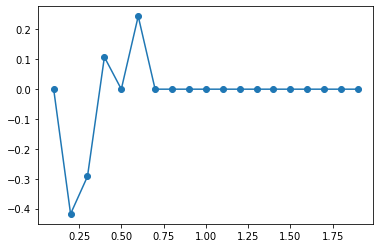

In [62]:
plt.plot(eps_range, silhouette, marker='o');

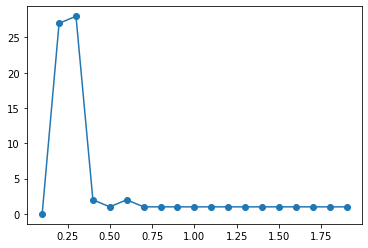

In [63]:
plt.plot(eps_range, clusters, marker='o');

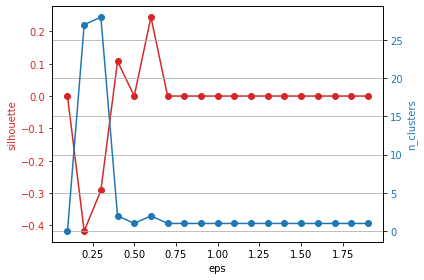

In [64]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(eps_range, silhouette, marker='o', color=color)
ax1.set_xlabel('eps')
ax1.set_ylabel('silhouette', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(eps_range, clusters, marker='o', color=color)
ax2.set_ylabel('n_clusters', color=color)  
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid()
plt.show()

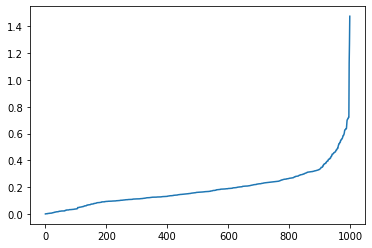

In [65]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5)
nbrs = neighbors.fit(cluster_scaled)
distance, indices = nbrs.kneighbors(cluster_scaled)

distance = np.sort(distance, axis=0)
distance = distance[:,1]
plt.plot(distance)

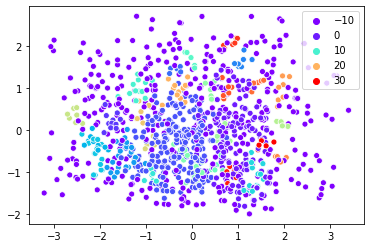

In [66]:
dbscan = DBSCAN(eps=0.3).fit(cluster_scaled)
labels = dbscan.labels_
sns.scatterplot(pca_samples[:,0], pca_samples[:,1], hue=labels, palette='rainbow');